<a href="https://colab.research.google.com/github/ornkkk/DeepLearning-GANs/blob/main/Vanilla_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [12]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

#### Defining some useful variables

In [13]:
img_height = 28
img_width = 28
channels = 1
img_shape = (img_height, img_width, channels)
z_dim = 100 # Dimension of noise vector, z

## Modelling a Simple Vanilla GAN

#### Implementing Generator

- We implement a simple generator with a single hidden layer. It takes noise vector, $z$ as input and produces a $28\times 28\times 1$ image as output. We use $Leaky~ReLU$ activation in the hidden layer and $tanh$ activation in the output layer. 

- $tanh$ activation at output layer tends to produce sharper images as comapared to $sigmoid$ activation in output layer.

In [14]:
def build_generator(img_shape, z_dim):
  model = Sequential()
  model.add(Dense(128, input_dim=z_dim))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(img_shape[0] * img_shape[1] * img_shape[2], activation='tanh'))
  model.add(Reshape(img_shape))
  return model

#### Implementing Discriminator

- We implement a simple discriminator with a single hidden layer. It takes flattened image of size $28\times 28\times 1$ as input and produces a probability score whether the image is real. We use $Leaky~ReLU$ activation in the hidden layer and $sigmoid$ activation in the output layer. 

In [15]:
def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(1, activation='sigmoid'))
  return model

#### Implementing GAN

In [16]:
def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

#### Compiling Model

- We set `discriminator.trainable = False` to keep Discriminator's parameters constant for Generator training.

- We use $Adam$ optimizer and $Binary~Cross~Entropy$ loss for both Discriminator and GAN while compiling the model.

In [17]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

#### Training the model

- We use normal GAN training algorithm to train our model.
- `sample_images` function gets called every `sample_interval` iterations in  and outputs a
  $4 \times 4$ grid of images synthesized by the Generator in the given iteration. After we run our model, we will use these images to inspect the outputs

In [26]:
losses = []
accuracies = []
epoch_checkpoints = []

def train(epochs, batch_size, sample_interval):
  # Loading MNIST dataset
  (X_train, _), (_, _) = mnist.load_data()
  
  # Rescaling Pixel Values
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)
  
  # Generating labels for real and fake images
  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))
  
  for epoch in range(epochs):
    # Getting a batch of random real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Generating a batch of fake images using Normal Distribution
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Training the Discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Generating a batch of fake images using Normal Distribution
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Training the Generator
    g_loss = gan.train_on_batch(z, real)

    if (epoch + 1) % sample_interval == 0:
      # Saving metrics for plotting
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      epoch_checkpoints.append(epoch + 1)
    
      print(f"{epoch+1} [Discriminator loss: {d_loss:.5f}, accuracy: {100.0*accuracy:.2f}%%] [Generator loss: {g_loss:.5f}]")
      sample_images(generator, epoch+1)

In [27]:
def sample_images(generator, epoch, image_grid_rows=4, image_grid_columns=4):
  # Sampling random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # Generating images from random noise
  gen_imgs = generator.predict(z)

  # Rescaling image pixels to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Setting image grid
  fig, axs = plt.subplots(image_grid_rows, image_grid_columns,
                          figsize=(4, 4), sharey=True, sharex=True)
  fig.suptitle(f"Generated images after {epoch} epochs")
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

#### Running the Model
- We run the model for $25000$ iterations with `batch_size = 128` and `sample_interval = 1000`.

1000 [Discriminator loss: 0.07575, accuracy: 96.88%%] [Generator loss: 5.05181]
2000 [Discriminator loss: 0.03309, accuracy: 99.22%%] [Generator loss: 4.79401]
3000 [Discriminator loss: 0.21102, accuracy: 91.80%%] [Generator loss: 5.54401]
4000 [Discriminator loss: 0.18235, accuracy: 92.97%%] [Generator loss: 5.10502]
5000 [Discriminator loss: 0.14081, accuracy: 93.75%%] [Generator loss: 5.22113]
6000 [Discriminator loss: 0.29925, accuracy: 89.06%%] [Generator loss: 3.46103]
7000 [Discriminator loss: 0.23792, accuracy: 90.62%%] [Generator loss: 4.44758]
8000 [Discriminator loss: 0.27444, accuracy: 87.11%%] [Generator loss: 3.27191]
9000 [Discriminator loss: 0.34129, accuracy: 84.77%%] [Generator loss: 3.70180]
10000 [Discriminator loss: 0.23697, accuracy: 90.23%%] [Generator loss: 3.74774]
11000 [Discriminator loss: 0.36993, accuracy: 85.16%%] [Generator loss: 2.53237]
12000 [Discriminator loss: 0.34032, accuracy: 86.33%%] [Generator loss: 3.18639]
13000 [Discriminator loss: 0.32049, a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


22000 [Discriminator loss: 0.20662, accuracy: 91.41%%] [Generator loss: 3.24337]
23000 [Discriminator loss: 0.36661, accuracy: 85.16%%] [Generator loss: 2.77221]
24000 [Discriminator loss: 0.40490, accuracy: 82.03%%] [Generator loss: 2.76939]
25000 [Discriminator loss: 0.51493, accuracy: 73.83%%] [Generator loss: 2.18852]


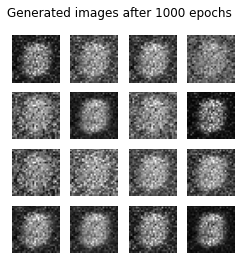

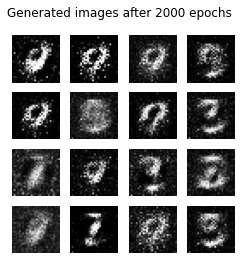

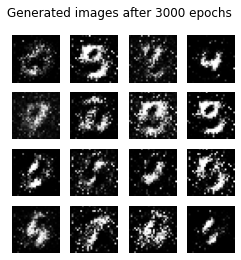

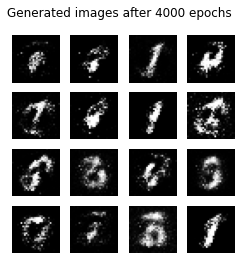

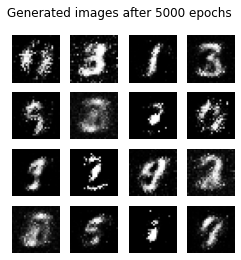

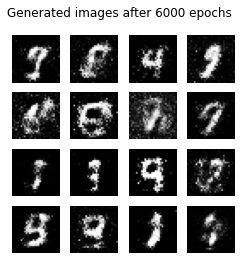

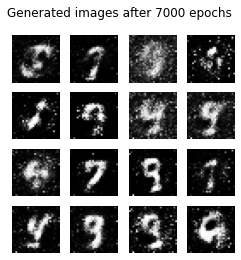

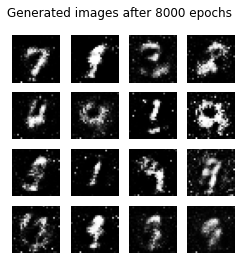

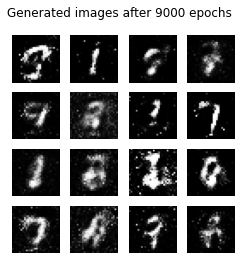

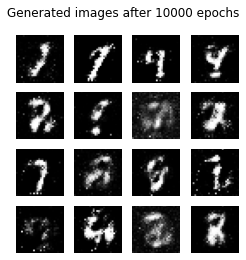

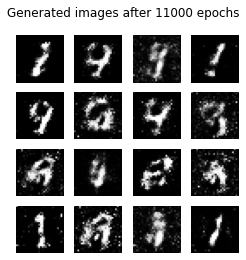

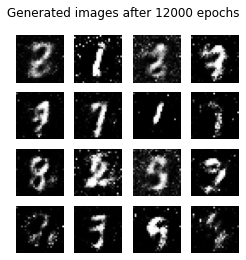

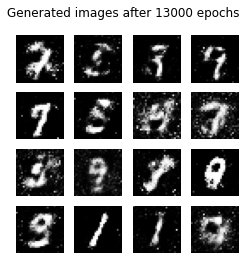

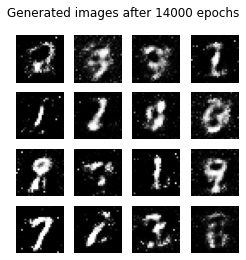

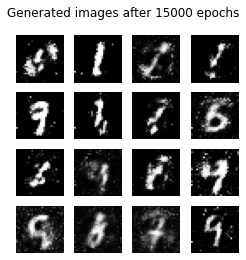

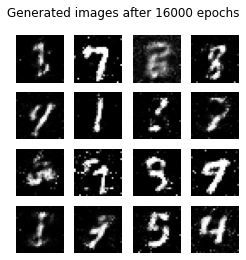

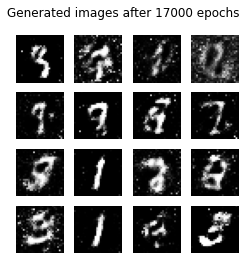

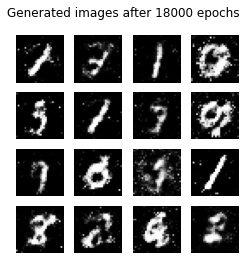

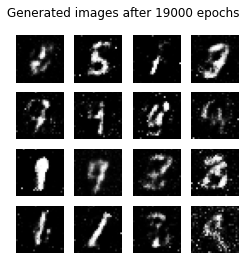

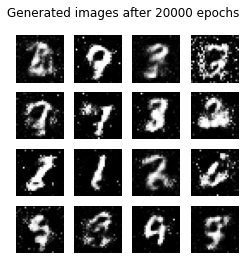

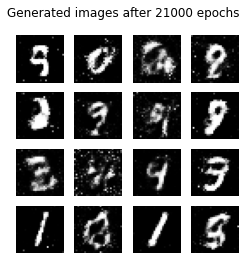

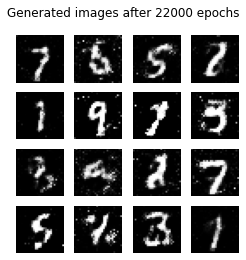

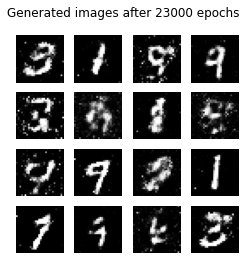

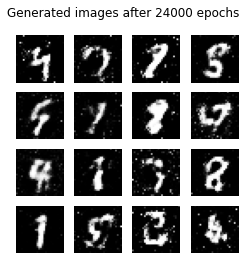

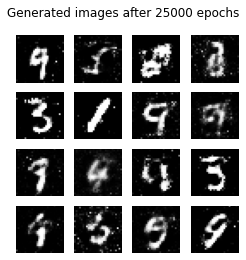

In [29]:
iterations = 25000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

- We can observe from the above output that the initial images are random noises. The Generator gradually learns and generates better and better images.
- We can also observe that these images are not perfect, but our Generator learned to produce realistic looking digits, such as $1$, $3$ and $9$.

#### Plotting Metrics

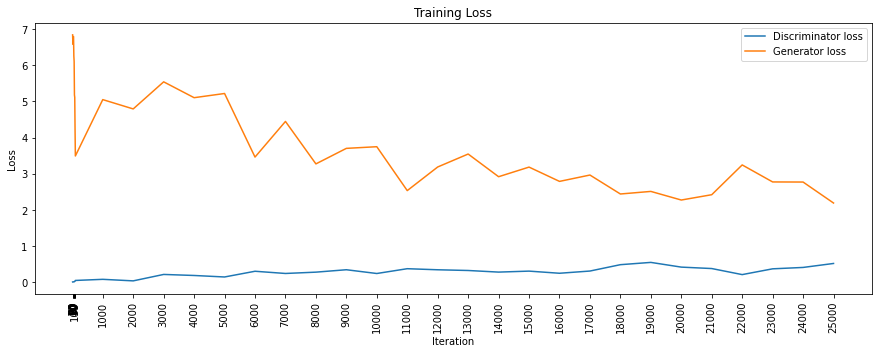

In [31]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(epoch_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(epoch_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(epoch_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

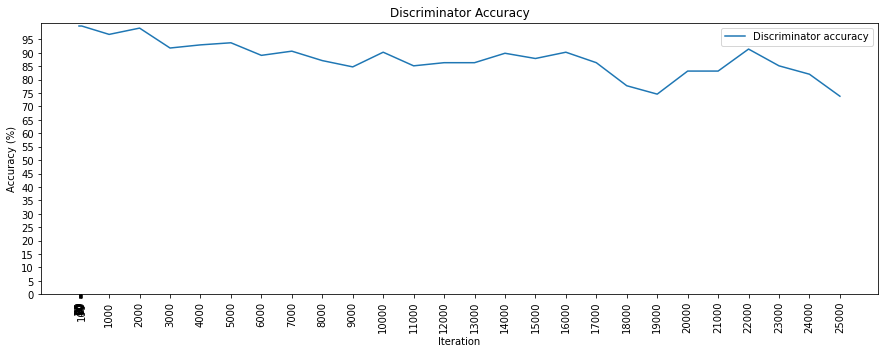

In [32]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(epoch_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(epoch_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()